## Load libraries

In [1]:
# Imports
import numpy as np
from numpy import genfromtxt
import matplotlib 
from matplotlib import pyplot as plt
import pandas as pd
import os
%matplotlib inline
import multiprocessing

import sklearn
import dcor

import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.lpcmci import LPCMCI
import tigramite.independence_tests 

from tigramite.toymodels import structural_causal_processes as toys

## Data processing

In [2]:
df = pd.read_parquet("amalgamated.parquet")

In [3]:
df.columns

Index(['AdrActCnt', 'AdrBal1in100KCnt', 'AdrBal1in100MCnt', 'AdrBal1in10BCnt',
       'AdrBal1in10KCnt', 'AdrBal1in10MCnt', 'AdrBal1in1BCnt',
       'AdrBal1in1KCnt', 'AdrBal1in1MCnt', 'AdrBalCnt',
       ...
       'EWL', 'ERUS', 'EWZ', 'EWY', 'ENZL', 'EWD', 'EWM',
       'Global_Liquidity_Index', 'Normalized_GLI', 'Normalized_SPY'],
      dtype='object', length=166)

In [4]:
#df = df.drop(columns=['time']).reset_index(drop=True)

In [5]:
df.shape

(1438, 166)

In [6]:
df = df.tail(520)

In [7]:
df = df.reset_index(drop=True)

In [8]:
metrics = [
    "ReferenceRateUSD",
    "AdrBalNtv0.01Cnt",
    "AdrBalNtv0.1Cnt",
    "AdrBalNtv1Cnt",
    "BlkSizeMeanByte",
    "FeeByteMeanNtv",
    "FlowInExNtv",
    "FlowOutExNtv",
    "HashRate",
    "SplyAct1d",
    "TxCnt",
    "^IRX",
    "^TNX",
    "^TYX",
    "SPY",
    "QQQ",
    "Global_Liquidity_Index"
]

In [9]:
df = df[metrics]
df

,ReferenceRateUSD,AdrBalNtv0.01Cnt,AdrBalNtv0.1Cnt,AdrBalNtv1Cnt,BlkSizeMeanByte,FeeByteMeanNtv,FlowInExNtv,FlowOutExNtv,HashRate,SplyAct1d,TxCnt,^IRX,^TNX,^TYX,SPY,QQQ,Global_Liquidity_Index
0,62373.885621,9139450,3245357,811625,1.144247e+06,8.769500e-08,30343.055196,23819.745636,1.577321e+08,475158.767625,281476,0.050,1.655,2.091,453.119995,374.100006,933.780292
1,60865.447052,9141570,3244036,809011,1.112111e+06,6.967900e-08,15663.127389,35089.685077,1.816914e+08,464062.257587,286798,0.050,1.635,2.085,455.549988,377.929993,940.034018
2,63031.672902,9143940,3242600,806994,1.219891e+06,7.515300e-08,16941.822580,23947.233902,1.497457e+08,437036.850081,295695,0.050,1.619,2.051,455.959991,379.119995,942.110898
3,60393.980274,9147841,3243043,807146,1.090372e+06,7.155900e-08,22701.109195,23099.529453,1.567338e+08,413406.751805,286086,0.050,1.529,1.942,453.940002,380.000000,941.845493
4,58563.335990,9151206,3244074,807420,1.251451e+06,6.816600e-08,35624.404543,23147.724894,1.527406e+08,370589.037579,297884,0.048,1.568,1.963,458.320007,384.220001,950.290018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,43605.155555,12724066,4583262,1023340,1.708325e+06,1.627281e-06,20075.140452,20332.299706,4.884860e+08,298825.317741,589222,5.210,3.894,4.036,472.700012,407.769989,973.185377
516,43870.238234,12719547,4580759,1023231,1.700745e+06,1.109639e-06,25767.774305,21488.599482,5.620935e+08,280265.014624,623750,5.208,3.901,4.054,473.649994,408.380005,974.601569
517,42491.122908,12733838,4580040,1023628,1.670873e+06,1.275813e-06,15074.672745,31705.858513,4.617484e+08,343694.296619,541778,5.235,3.789,3.945,476.510010,411.500000,981.543728
518,43436.959427,12743326,4581886,1023743,1.695263e+06,1.114453e-06,15879.873592,18531.696665,4.331128e+08,303730.031379,417387,5.218,3.850,3.988,476.690002,411.299988,981.290662


In [10]:
array = df.to_numpy()

In [11]:
from tigramite.independence_tests.parcorr_mult import ParCorrMult
from tigramite.independence_tests.cmiknn import CMIknn

var_names = metrics

parcorr = ParCorrMult()
cmi = CMIknn()

df_final = pp.DataFrame(array, var_names=var_names)

## LPCMCI

In [12]:
%%time

lpcmci_aug = LPCMCI(dataframe=df_final, 
                cond_ind_test=parcorr,
                verbosity=0)

# Define the analysis parameters
tau_max = 5
pc_alpha = 0.01
#max_cond_px = 2  # Example value, adjust based on your data
#max_p_global = 2 # Use the default unless computational time is a concern
#max_p_non_ancestral = 2 # Same as above
#max_q_global = 5  # Same as above
#max_pds_set = 5  # Same as above
#n_preliminary_iterations = 2  # Adjust as needed

# Run LPCMCI
result = lpcmci_aug.run_lpcmci(
    tau_max=tau_max,
    pc_alpha=pc_alpha
#    max_cond_px=max_cond_px,
#    max_p_global=max_p_global,
#    max_p_non_ancestral=max_p_non_ancestral,
#    max_q_global=max_q_global,
#    max_pds_set=max_pds_set,
#    n_preliminary_iterations=n_preliminary_iterations
)

CPU times: user 2min 33s, sys: 789 ms, total: 2min 34s
Wall time: 2min 34s


## Plotting

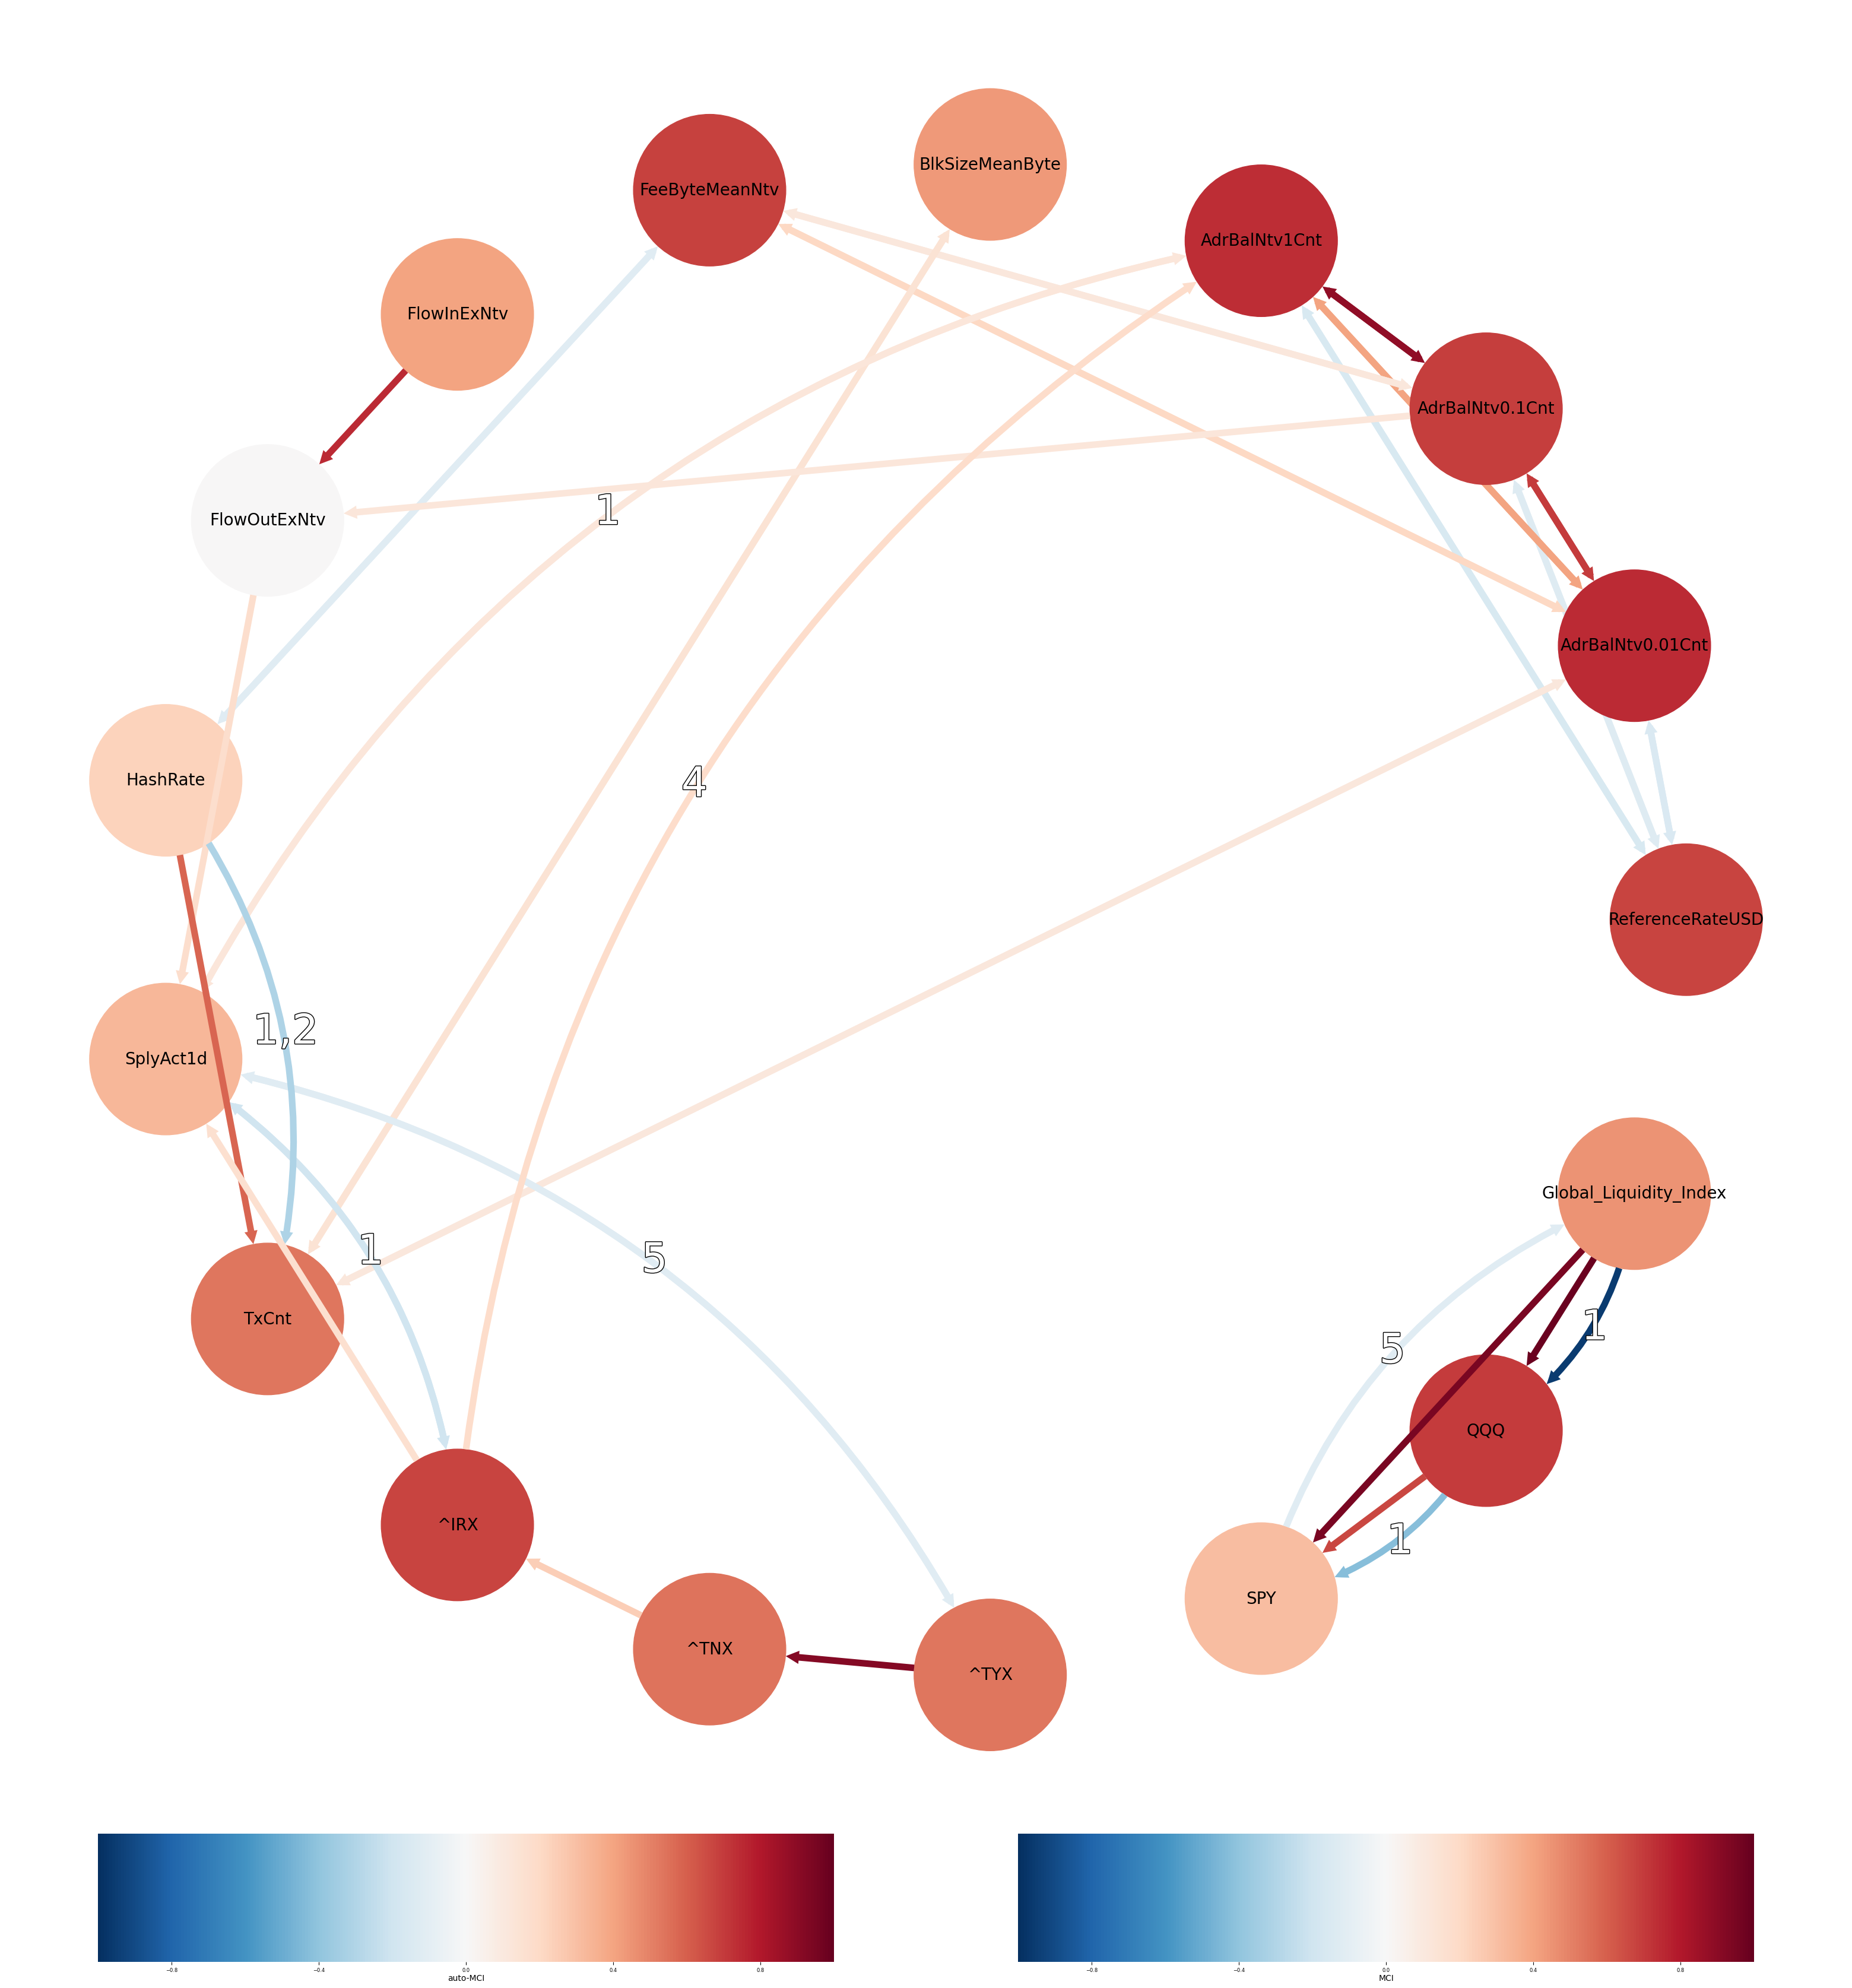

CPU times: user 3.48 s, sys: 731 ms, total: 4.21 s
Wall time: 3.26 s


In [13]:
%%time

tp.plot_graph(
    figsize=(40, 40),
    val_matrix=result['val_matrix'],
    graph=result['graph'],
    var_names=var_names,
    link_colorbar_label='MCI',
    node_size=0.2,
    node_label_size = 20,
    link_label_fontsize = 50,
    curved_radius = 0.25
)

# Save the plot to an SVG file before showing it
plt.savefig('lpcmci_graph.jpg', format='jpg')

plt.show()

In [14]:
# Initialize a list to store the relation information
relation_info = []

# Iterate over the rows, columns, and tau of the graph matrix
for i, x_var in enumerate(var_names):
    for j, y_var in enumerate(var_names):
        for tau in range(result['graph'].shape[2]):
            relation = result['graph'][i, j, tau]

            # Check if the relation is not an empty string
            if relation:
                mci_val = result['val_matrix'][i, j]
                p_val = result['p_matrix'][i, j]

                # Check if mci_val and p_val are arrays and extract the first element
                if isinstance(mci_val, np.ndarray) and mci_val.size > 0:
                    mci_val = mci_val[0]
                if isinstance(p_val, np.ndarray) and p_val.size > 0:
                    p_val = p_val[0]

                # Append the relation information to the list only if abs(MCI) >= 0.001 and p-value < pc_alpha
                if mci_val is not None and p_val is not None and abs(mci_val) >= 0.001 and p_val < pc_alpha:
                    relation_info.append((x_var, y_var, tau, relation, mci_val, p_val))

# Sort the list by MCI value in descending order
relation_info.sort(key=lambda x: x[4], reverse=True)

# Print the sorted information
for x_var, y_var, tau, relation, mci_val, p_val in relation_info:
    print(f"Relation between '{x_var}' and '{y_var}' at lag {tau}:")
    print(f"  Type: {relation}")
    print(f"  MCI Value: {mci_val:.4f}")  # Adjust the number of decimal places as needed
    print(f"  P-Value: {p_val:.4g}")  # Adjust the number of decimal places as needed
    print("-" * 40)  # Separator for readability


Relation between 'QQQ' and 'Global_Liquidity_Index' at lag 0:
  Type: <--
  MCI Value: 0.9852
  P-Value: 0
----------------------------------------
Relation between 'Global_Liquidity_Index' and 'QQQ' at lag 0:
  Type: -->
  MCI Value: 0.9852
  P-Value: 0
----------------------------------------
Relation between 'Global_Liquidity_Index' and 'QQQ' at lag 1:
  Type: -->
  MCI Value: 0.9852
  P-Value: 0
----------------------------------------
Relation between 'SPY' and 'Global_Liquidity_Index' at lag 0:
  Type: <--
  MCI Value: 0.9528
  P-Value: 6.553e-260
----------------------------------------
Relation between 'SPY' and 'Global_Liquidity_Index' at lag 5:
  Type: -->
  MCI Value: 0.9528
  P-Value: 6.553e-260
----------------------------------------
Relation between 'Global_Liquidity_Index' and 'SPY' at lag 0:
  Type: -->
  MCI Value: 0.9528
  P-Value: 6.553e-260
----------------------------------------
Relation between '^TNX' and '^TYX' at lag 0:
  Type: <--
  MCI Value: 0.9211
  P-Valu

In [15]:
# Initialize a list to store the auto-relation information
auto_relation_info = []

# Define tau_max
tau_max = result['graph'].shape[2]

# Iterate over the variables
for i, var in enumerate(var_names):
    total_mci_val = 0
    total_p_val = 0
    count = 0

    # Accumulate the MCI values and p-values from 0 to tau_max
    for tau in range(tau_max):
        if result['graph'][i, i, tau]:
            mci_val = result['val_matrix'][i, i, tau]
            p_val = result['p_matrix'][i, i, tau]

            # Extract the first element if they are arrays
            if isinstance(mci_val, np.ndarray) and mci_val.size > 0:
                mci_val = mci_val[0]
            if isinstance(p_val, np.ndarray) and p_val.size > 0:
                p_val = p_val[0]

            # Accumulate values
            if mci_val is not None and p_val is not None:
                total_mci_val += mci_val
                total_p_val += p_val
                count += 1

    # Calculate averages if count is non-zero
    if count > 0:
        avg_mci_val = total_mci_val / count
        avg_p_val = total_p_val / count
        auto_relation_info.append((var, avg_mci_val, avg_p_val))

# Sort the list by average MCI value in descending order
auto_relation_info.sort(key=lambda x: x[1], reverse=True)

# Print the sorted information
for var, avg_mci_val, avg_p_val in auto_relation_info:
    print(f"Average Auto-MCI of '{var}':")
    print(f"  Average MCI Value: {avg_mci_val:.4f}")  # Adjust the number of decimal places as needed
    print(f"  Average P-Value: {avg_p_val:.4g}")  # Adjust the number of decimal places as needed
    print("-" * 40)  # Separator for readability


Average Auto-MCI of 'AdrBalNtv0.01Cnt':
  Average MCI Value: 0.7483
  Average P-Value: 1.626e-91
----------------------------------------
Average Auto-MCI of 'QQQ':
  Average MCI Value: 0.6962
  Average P-Value: 1.965e-74
----------------------------------------
Average Auto-MCI of 'ReferenceRateUSD':
  Average MCI Value: 0.6750
  Average P-Value: 2.718e-68
----------------------------------------
Average Auto-MCI of '^TNX':
  Average MCI Value: 0.5433
  Average P-Value: 3.398e-40
----------------------------------------
Average Auto-MCI of '^TYX':
  Average MCI Value: 0.5372
  Average P-Value: 2.558e-39
----------------------------------------
Average Auto-MCI of 'Global_Liquidity_Index':
  Average MCI Value: 0.4500
  Average P-Value: 1.362e-26
----------------------------------------
Average Auto-MCI of 'FlowInExNtv':
  Average MCI Value: 0.4060
  Average P-Value: 1.691e-21
----------------------------------------
Average Auto-MCI of 'SplyAct1d':
  Average MCI Value: 0.3339
  Average